In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import models, layers, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime

In [24]:
%load_ext tensorboard
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# only run on colab
from google.colab import drive
drive.mount('/content/drive')

In [2]:
train_data = np.load('./data/train.npz') if 'Eric' in os.uname().nodename else np.load('/content/drive/MyDrive/Colab Notebooks/data/train.npz')
#test_data = np.load('./data/public_test.npz') if 'Eric' in os.uname().nodename else np.load('/content/drive/MyDrive/Colab Notebooks/data/public_test.npz')

In [3]:
# separate bands and labels into individual data structures to improve performance
x_train = train_data['bands']
y_train = train_data['lulc']

# add class labels manually
classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])

In [ ]:
x_train_flattened = x_train.reshape((120000, 33, 33, 6))
y_train_flattened = np.array(list(map(lambda x: np.repeat(x, n_months), y_train))).reshape((120000))

In [4]:
np.histogram(y_train, bins=list(range(len(classes) + 1)))

(array([1308,  238, 5796, 1125,  770,   58,    0,    0,  217,  488,    0]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))

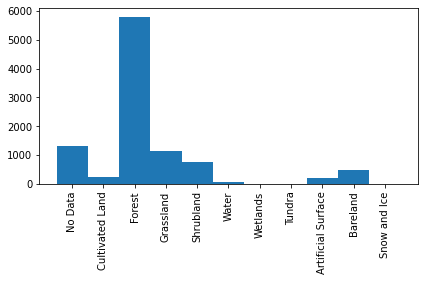

In [25]:
plt.hist(y_train, bins=list(range(len(classes) + 1)))
plt.xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))), labels=classes, rotation=90)
plt.tight_layout()
plt.show()

In [6]:
n_patches = x_train.shape[0]
n_months = x_train.shape[1]
n_classes = len(classes)
n_channels = x_train.shape[4]
f'patches: {x_train.shape}, labels: {y_train.shape}, classes: {classes.shape}'

'patches: (10000, 12, 33, 33, 6), labels: (10000,), classes: (11,)'

In [7]:
# draw random patches
n_samples = 10
samples = np.random.randint(n_patches, size=n_samples)

In [ ]:
# plot random samples from the training set
f, axes = plt.subplots(n_samples, n_months, figsize=(33,33))
for idx, sample in enumerate(samples):
    for month in range(n_months):
        axes[idx][month].imshow(x_train[sample][month][:, :, (2, 1, 0)])
        axes[idx][month].set_title(f'{classes[y_train[sample]]} - {month}')
f.tight_layout()
plt.tight_layout()
plt.show()

In [ ]:
# plot the test set
#f, axes = plt.subplots(1, n_months, figsize=(500,500))

#for month in range(n_months):
    #axes[month].imshow(test_bands[month][:, :, (2, 1, 0)])

In [ ]:
idx_no_data = np.argwhere(y_train == 3).flatten()[:20]
# plot images labelled with no data
f, axes = plt.subplots(len(idx_no_data), n_months, figsize=(33,33))
for idx, patch in enumerate(idx_no_data):
    for month in range(n_months):
        axes[idx][month].imshow(x_train[patch][month][:, :, (2, 1, 0)])
        axes[idx][month].set_title(f'p: {patch} - l: {classes[y_train[patch]]} - m: {month}')
f.tight_layout()
plt.tight_layout()
plt.show()

Try different models

In [120]:
# This model is similar to the VGGNets

model = models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=None, input_shape=(33,33,6)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dropout(0.4))
model.add(layers.Dense(units=12, activation = 'softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 33, 33, 64)        3520      
_________________________________________________________________
batch_normalization (BatchNo (None, 33, 33, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 33, 33, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 33, 64)        256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 33, 33, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)       

In [ ]:
model = models.Sequential()

#model.add(layers.InputLayer(input_shape=(33, 33, 6)))
model.add(layers.Conv3D(filters=64, kernel_size=(1, 3, 3), padding='same', input_shape=(12, 33, 33, 6)))
model.add(layers.ReLU()) 
model.add(layers.GlobalAveragePooling3D())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(units=12, activation = 'softmax'))

model.summary()

In [ ]:
model = models.Sequential()
model.add(layers.Conv3D(32, (1, 3, 3), activation='relu', input_shape=(12, 33, 33, 6)))
model.add(layers.MaxPooling3D((1, 2, 2)))
model.add(layers.Conv3D(64, (1, 3, 3), activation='relu'))
model.add(layers.MaxPooling3D((3, 3, 3)))
model.add(layers.Conv3D(64, (1, 3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(12, activation='softmax'))
model.summary()

Current model

In [116]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(33, 33, 6)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(12, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 31, 32)        1760      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [121]:
# We use the Categorical Crossentropy (Classification Task) as Loss-Function and Adam as the optimizer
model.build()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [122]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

2021-07-08 14:13:25.292989: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-08 14:13:25.293036: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-08 14:13:25.293311: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [123]:
history = model.fit(x=x_train_flattened, y=y_train_flattened, epochs=5, callbacks=[tensorboard_callback], validation_split=0.2)

Epoch 1/5
   1/3000 [..............................] - ETA: 3:22:16 - loss: 3.1347 - accuracy: 0.0000e+002021-07-08 14:13:39.407111: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-08 14:13:39.407143: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
   2/3000 [..............................] - ETA: 58:56 - loss: 2.7438 - accuracy: 0.2188      2021-07-08 14:13:40.683878: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-07-08 14:13:40.688019: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-08 14:13:40.691777: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20210708-141325/train/plugins/profile/2021_07_08_14_13_40
2021-07-08 14:13:40.700589: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/20210708-141325/train/plugins/

KeyboardInterrupt: 

In [17]:
%tensorboard --logdir logs/fit --port=8008

Reusing TensorBoard on port 8008 (pid 18957), started 20:01:46 ago. (Use '!kill 18957' to kill it.)

In [19]:
preds = model.predict(x_train[:, 0, :, :, :])
np.histogram(preds.argmax(1), bins=list(range(len(classes) + 1)))

(array([ 360,    0, 8682,   47,  242,    0,    0,    0,    0,  669,    0]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))

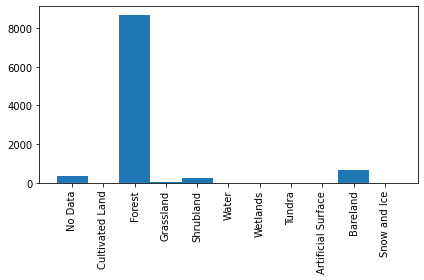

In [22]:
# plot prediction histogram
plt.hist(preds.argmax(1), bins=list(range(len(classes) + 1)))
plt.xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))), labels=classes, rotation=90)
plt.tight_layout()
plt.show()

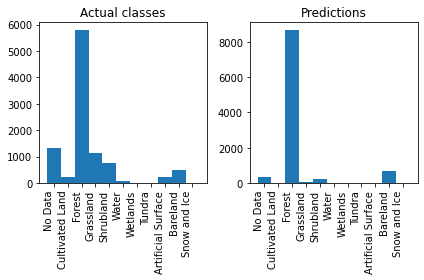

In [53]:
f, axes = plt.subplots(1, 2)
axes[0].hist(y_train, bins=list(range(len(classes) + 1)))
axes[0].set_xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))))
axes[0].set_xticklabels(classes, rotation=90, ha='right')
axes[0].set_title('Actual classes')
axes[1].hist(preds.argmax(1), bins=list(range(len(classes) + 1)))
axes[1].set_xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))))
axes[1].set_xticklabels(classes, rotation=90, ha='right')
axes[1].set_title('Predictions')
plt.tight_layout()
plt.show()

In [76]:
x_train.reshape((120000, 33, 33, 6))[12, :, :, :]

array([[[0.1139, 0.0761, 0.0581, 0.0769, 0.0708, 0.0438],
        [0.1178, 0.0756, 0.0579, 0.0817, 0.0708, 0.0438],
        [0.1198, 0.081 , 0.0646, 0.0967, 0.1009, 0.0607],
        ...,
        [0.119 , 0.0779, 0.0583, 0.0719, 0.0721, 0.0428],
        [0.1163, 0.0728, 0.0541, 0.0598, 0.0721, 0.0428],
        [0.1266, 0.0842, 0.0597, 0.0769, 0.0687, 0.0358]],

       [[0.1143, 0.0745, 0.057 , 0.0771, 0.076 , 0.0439],
        [0.1193, 0.079 , 0.063 , 0.0964, 0.076 , 0.0439],
        [0.1238, 0.0866, 0.0702, 0.1108, 0.1311, 0.0833],
        ...,
        [0.1187, 0.077 , 0.0574, 0.0607, 0.0614, 0.0351],
        [0.1164, 0.0737, 0.0547, 0.0529, 0.0614, 0.0351],
        [0.1253, 0.0798, 0.0564, 0.0684, 0.0768, 0.0453]],

       [[0.1153, 0.0727, 0.0545, 0.0642, 0.076 , 0.0439],
        [0.117 , 0.0812, 0.0624, 0.09  , 0.076 , 0.0439],
        [0.1241, 0.0833, 0.0709, 0.1124, 0.1311, 0.0833],
        ...,
        [0.1195, 0.0756, 0.0573, 0.0587, 0.0614, 0.0351],
        [0.1185, 0.0763, 0.06

In [110]:
print(y_train[300:302])
print(y_train_flattened[3600:3613])

[4 2]
[4 4 4 4 4 4 4 4 4 4 4 4 2]
